In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "archive/Multi Cancer/data/Brain Cancer"
test_url = "archive/Multi Cancer/data/test"

data_dir = pathlib.Path(dataset_url).with_suffix('')
test_dir = pathlib.Path(test_url).with_suffix('')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count, test_count)

12750 2250


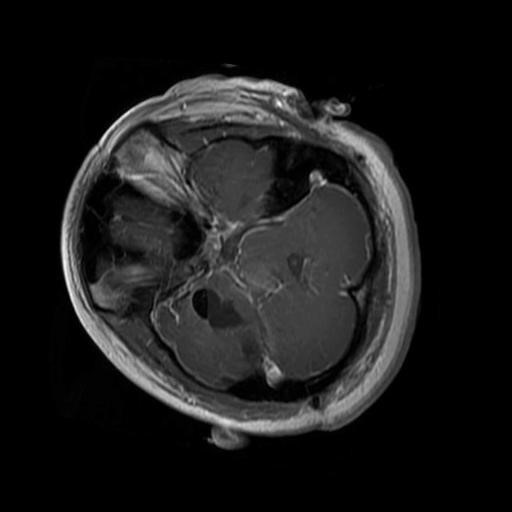

In [5]:
brain_glioma = list(data_dir.glob('brain_glioma/*'))
PIL.Image.open(str(brain_glioma[2]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 10200 files for training.


In [8]:
# augment training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2), 
    layers.RandomBrightness(0.2),  
    layers.RandomContrast(0.2), 
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12750 files belonging to 3 classes.
Using 2550 files for validation.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2250 files belonging to 3 classes.


In [11]:
class_names = train_ds.class_names
class_names

AttributeError: 'MapDataset' object has no attribute 'class_names'

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(i)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
epochs=100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:   
   y_true.append(label_batch.numpy())
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
test_images, test_labels = next(iter(test_ds))
predictions = model.predict(test_images)

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]

    text_color = 'green' if predicted_label == true_label else 'red'
    
    plt.title(f"Pred: {class_names[predicted_label]}, True: {class_names[true_label]}", color=text_color)
    plt.axis("off")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(correct_labels, predicted_labels)
cm

In [ ]:
cm_disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
cm_disp.plot()